# Predicting fertility rates 
This project will use machine learning to predict whether a country's fertility rate is above or below the replacement rate (2.1), based on several factors. This data was taken via Google Bigquery from a subset of the World Health Organization's public database.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data
Data contains health metrics from countries around the world in 2010. Region information has been added separately.

In [2]:
data = pd.read_csv('WorldHealthFertilityRates2010.csv', usecols=['country_name','indicator_name','value'])
data.head()

,country_name,indicator_name,value
0,Greenland,"Age at first marriage, female",31.2
1,Belize,"Age at first marriage, female",28.6
2,Bermuda,"Age at first marriage, female",30.6
3,Eswatini,"Age at first marriage, female",26.2
4,Afghanistan,"Age at first marriage, female",21.5


We see the dataframe is in long form, which we'll have to change for some analysis. The indicator names are also long and contain characters such as spaces and commas, which will make things difficult in further analysis. We'll adjust the indicator names to short abbreviations.

In [3]:
data = data.replace({'indicator_name':{'Age at first marriage, female':'afm',
                                    'Lifetime risk of maternal death (%)':'lrd',
                                    'Nurses and midwives (per 1,000 people)':'nam',
                                    'Fertility rate, total (births per woman)':'fr',
                                    'Rural population (% of total population)':'rpop',
                                    'Labor force, female (% of total labor force)':'lff',
                                    'Unemployment, total (% of total labor force)':'ue',
                                    'School enrollment, tertiary, female (% gross)':'setf',
                                    'Mortality rate, infant (per 1,000 live births)':'mri',
                                    'Births attended by skilled health staff (% of total)':'bss',
                                    'Contraceptive prevalence, any methods (% of women ages 15-49)': 'con',
                                    'Risk of catastrophic expenditure for surgical care (% of people at risk)':'cex'
                    }})

#check that it was successful. The 'Region' indicator name is short enough we can leave it as it is
print(data.indicator_name.unique())

['afm' 'lrd' 'nam' 'fr' 'rpop' 'lff' 'ue' 'setf' 'mri' 'bss' 'con' 'cex'
 'Region']


Convert to wide form as this will help us further calculations

In [4]:
data = data.pivot(index = 'country_name',columns = 'indicator_name')
data.columns = data.columns.droplevel(0)

Since we interested in fertility rate ('fr') as our target variable and we're doing supervised machine learning, I'll immediately drop rows where 'fr' == NaN.

In [5]:
data.dropna(subset = ['fr'], inplace = True)

## Explore and Clean
Check data type of each variable

In [6]:
data.dtypes

indicator_name
Region    object
afm       object
bss       object
cex       object
con       object
fr        object
lff       object
lrd       object
mri       object
nam       object
rpop      object
setf      object
ue        object
dtype: object

Convert everything except region to numeric

In [7]:
numeric_vars = ['afm', 'lrd', 'nam', 'fr', 'rpop', 'lff', 'ue', 'setf', 'mri', 'bss', 'con', 'cex']
data[numeric_vars] = data[numeric_vars].apply(pd.to_numeric)
data.dtypes

indicator_name
Region     object
afm       float64
bss       float64
cex       float64
con       float64
fr        float64
lff       float64
lrd       float64
mri       float64
nam       float64
rpop      float64
setf      float64
ue        float64
dtype: object

## Convert fertility rate data to 2 categories
In this analysis we want to compare characteristics of countries on the basis of whether the fertility rate is above or below the replacement rate (2.1), so we will re-code the variable 'fr' with 'above' where fr >= 2.1 and 'below' where fr < 2.1.

In [8]:
data.fr = data.fr = data.fr.apply(lambda x: 'below' if x < 2.1 else 'above')
data.head()

indicator_name,Region,afm,bss,cex,con,fr,lff,lrd,mri,nam,rpop,setf,ue
country_name,,,,,,,,,,,,,
Afghanistan,Asia,21.5,34.3,NaN,21.8,above,15.479167,6.039311,64.1,NaN,76.263,NaN,11.52
Albania,Europe,NaN,NaN,NaN,NaN,below,42.444072,0.033876,11.8,4.0183,47.837,51.571091,14.09
Algeria,Africa,NaN,NaN,16.6,NaN,above,16.882805,0.344174,23.6,1.9470,32.460,35.421070,9.96
Andorra,Europe,NaN,NaN,NaN,NaN,below,NaN,NaN,4.3,4.7650,11.181,NaN,NaN
Angola,Africa,NaN,NaN,27.2,NaN,above,49.850111,2.151459,75.9,NaN,40.217,NaN,9.43


In [9]:
## Summary statistics

In [10]:
print(f'Total rows: {len(data)}')
data.describe()

Total rows: 198


indicator_name,afm,bss,cex,con,lff,lrd,mri,nam,rpop,setf,ue
count,77.000000,111.000000,129.000000,49.000000,185.000000,183.000000,183.000000,152.000000,196.000000,123.000000,185.000000
mean,22.932468,71.836486,26.498450,39.614774,40.854418,0.920860,25.775410,4.016938,42.981158,41.466081,8.254054
std,8.424267,38.866181,26.130125,29.397932,9.497626,1.558962,25.032142,3.752545,23.571972,32.562444,5.998852
min,1.000000,1.000000,0.100000,1.000000,11.413122,0.003041,1.000000,0.114000,1.000000,0.535210,0.450000
25%,21.600000,46.400000,1.000000,13.300000,37.768001,0.032675,5.450000,0.869200,23.528250,10.881490,4.030000
50%,24.400000,98.200000,20.200000,46.100000,43.917519,0.164156,16.200000,2.829800,42.997000,37.792278,7.150000
75%,28.500000,99.450000,43.600000,65.600000,47.251744,0.956909,42.100000,5.732825,61.474750,66.681480,10.850000
max,33.200000,99.960000,93.700000,89.100000,54.160085,8.463112,107.200000,16.665900,89.358000,118.624901,32.020000


From the 'count' row in the table above we see a lot of variables are missing data, since a complete data set would contain 198 values (the rows in the dataframe). This will have to be taken into account in further analysis, and eventually imputed.

There are also a lot of minimums of exactly 1.0 which is suspicious. This will have to be checked.

Plotting some quick histograms will help us get a feel for the spread of our data.

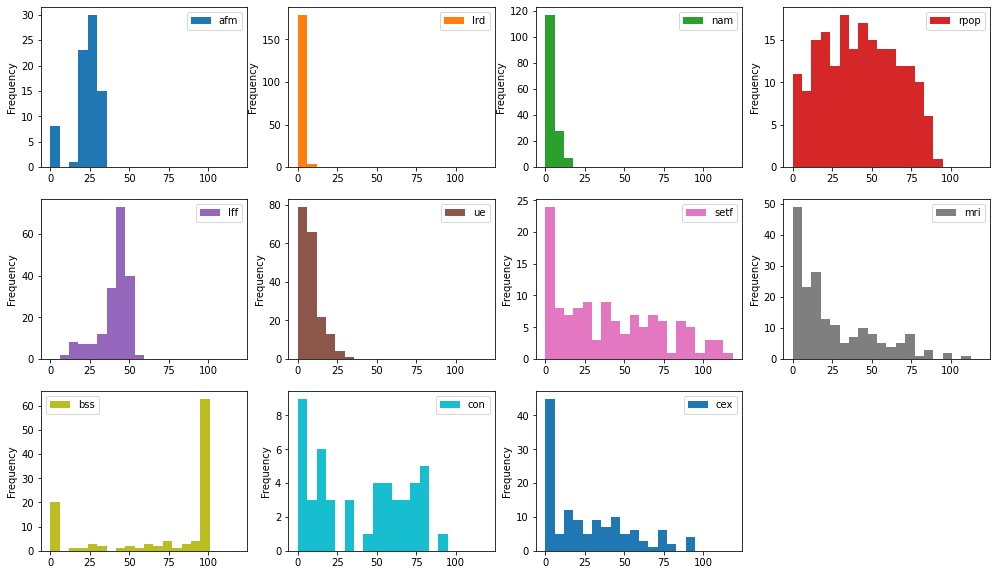

In [11]:
#define columns with independent numeric variables
numeric_ind = ['afm', 'lrd', 'nam', 'rpop', 'lff', 'ue', 'setf', 'mri', 'bss', 'con', 'cex']
data[numeric_ind].plot.hist(subplots = True, layout = (3,4), figsize = (17,10), sharex = False, bins = 20);


Although some variables aren't displayed so well, we can get a rough feeling for the distribution of others. One thing that's noticable is the amount of values around 1. Considering how many minimum values at 1.0 we saw in the summary statistics, it's possible that these peaks are at exactly 1. This makes me wonder if the data is real. For some variables with a peak at 1.0 (Age at first marriage, Births attended by skilled health staff, School enrollment, tertiary, female (% gross), or afm, bss, setf), this seems quite unlikely that the values at 1.0 real. Let's look at the frequency of values at 1.0 per row.

In [12]:
data[numeric_ind][data[numeric_ind] == 1].count()

indicator_name
afm      8
lrd      0
nam      0
rpop     5
lff      0
ue       2
setf     0
mri     11
bss     20
con      8
cex     18
dtype: int64

Although a 1.0 for some of these factors is more plausable than for others, to be safe (and consistent) we'll replace all the 1.0's with nan. Also to consider is that many of these values consist of decimal numbers, so it's unlikely we'd have several values at exactly 1.0. I suspect that in earlier versions of this dataset, missing values were once replaced with 1.0.

In [13]:
data[numeric_ind] = data[numeric_ind].replace(1,np.nan)

## Further Data Exploration
Let's see how much fertility rate data we're working with

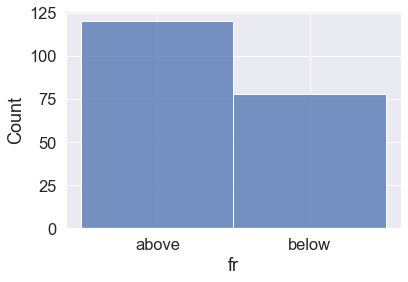

In [14]:
sns.set(font_scale = 1.5)
sns.histplot(data = data, x = 'fr');

About 75 datapoints where fertility rate is below replacement rate, and about 120 above. Not a perfect split, but not bad.
Let's see now how they're broken down by region.

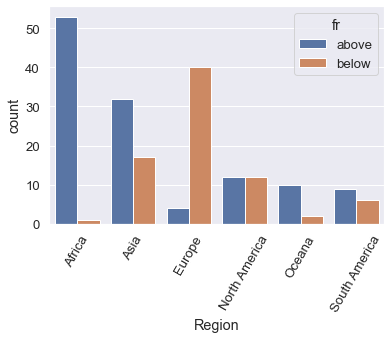

In [15]:
sns.set(font_scale = 1.2)
dataR = data[['Region','fr']].groupby(['Region','fr']).size().reset_index(name = 'count')
g = sns.barplot(data = dataR, x = 'Region', y = 'count', hue = 'fr');
plt.xticks(rotation=60);

In the above graph we can see apparent strong correlations with some regions, namely Africa, Europe, and Oceana. 

## Explore Numeric Variables
We can also use a few visualization techniques to see if we can spot any obvious trends with the continuous variables.
Because the continuous variables have different ranges, as can be seen from the summary table and earlier histograms, we will make the visualization easier by scaling the data first. It's important to note that we're scaling here with all the data, which means this scaling won't be valid (or won't be best practice) when we split the data into training and testing datasets later for machine learning. So, the scalar here is only used for the next 2 graphs. When we continue on to develop a model, we'll create a new scalar on the training set only.

For visualizing the continuous data, we can use color-coded histograms such as below.

- improve axes labels? x-axis to 'scaled value'?

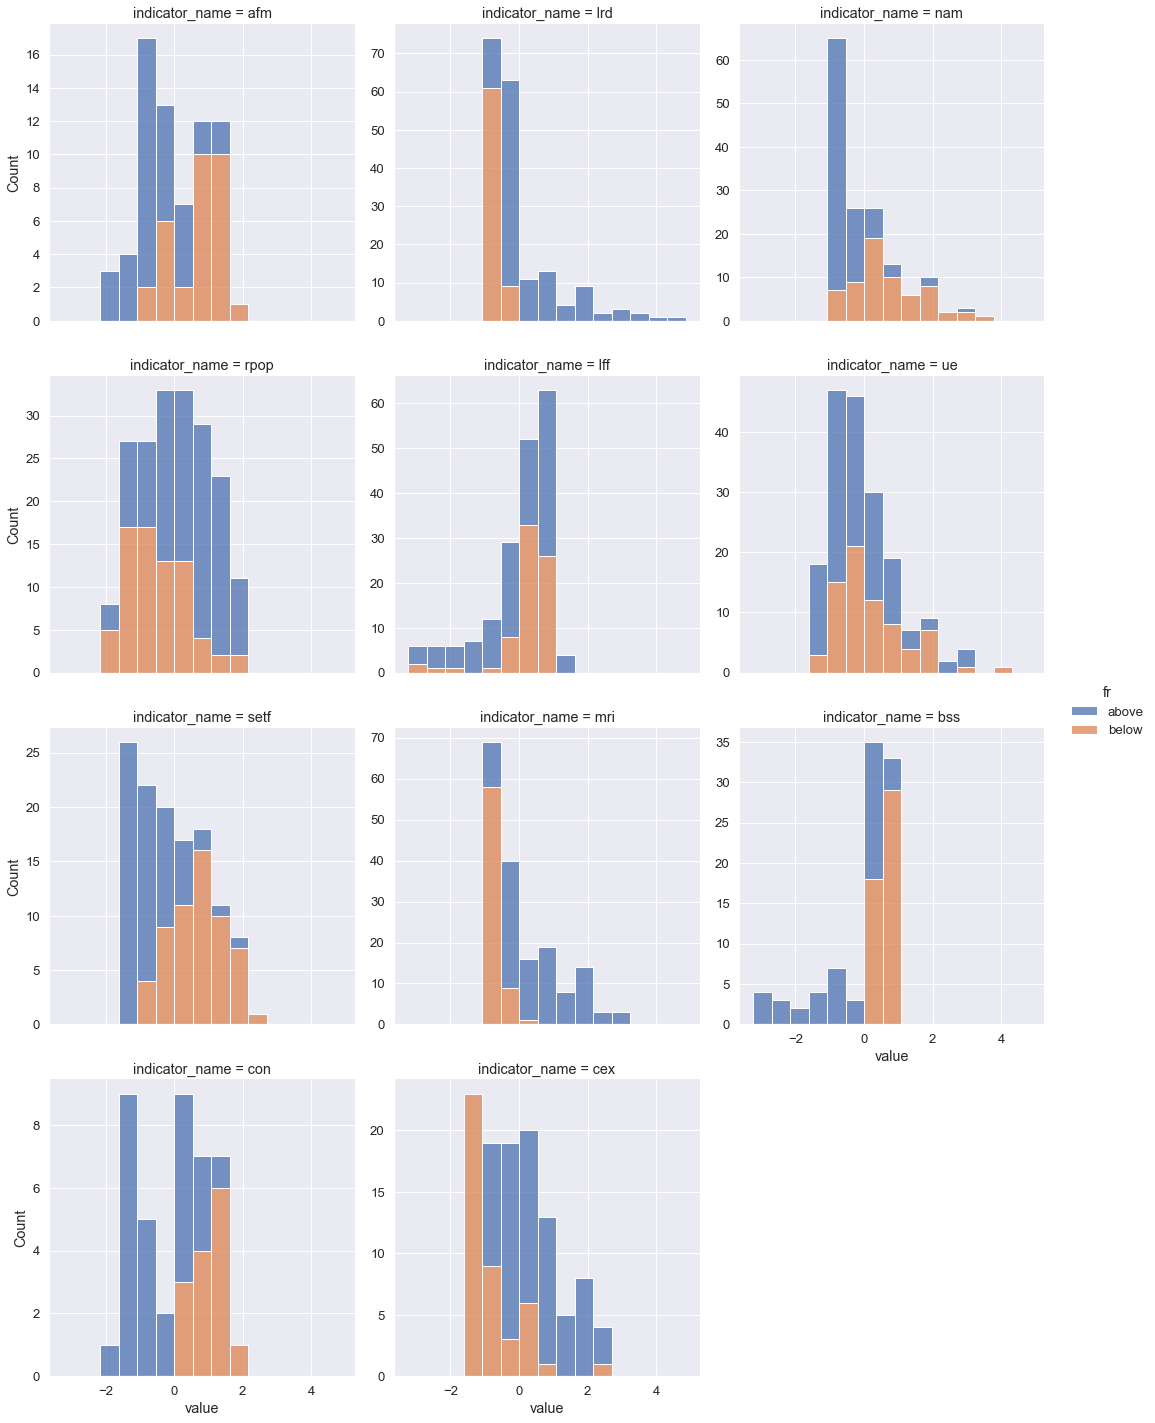

In [16]:
from sklearn.preprocessing import StandardScaler

#create a separate copy of the dataset so we preserve the original for later
data_allscaled = data.copy()

scaler_all = StandardScaler()
scaler_all.fit(data_allscaled[numeric_ind])
data_allscaled[numeric_ind] = scaler_all.transform(data_allscaled[numeric_ind])

data_tidy = pd.melt(data_allscaled, id_vars = 'fr', value_vars = numeric_ind)
sns.displot(data_tidy, x="value", col="indicator_name", hue='fr', multiple="stack", col_wrap=3, bins=15,
    facet_kws=dict(sharey=False));


From the above plots it looks like several factors, such as 'con', 'afm', 'ldr', 'mri', and 'bss' could indeed have a moderate to strong correlation with the fertility rate.

### Correlation Matrix
The correlation matrix will show us how all of the continuous variables are correlated with each other, but more importantly how correlated they are with fertility rate 'fr'. 
To make sure 'fr' is included, we first have to convert it to numeric (0 and 1) using LabelEncoder

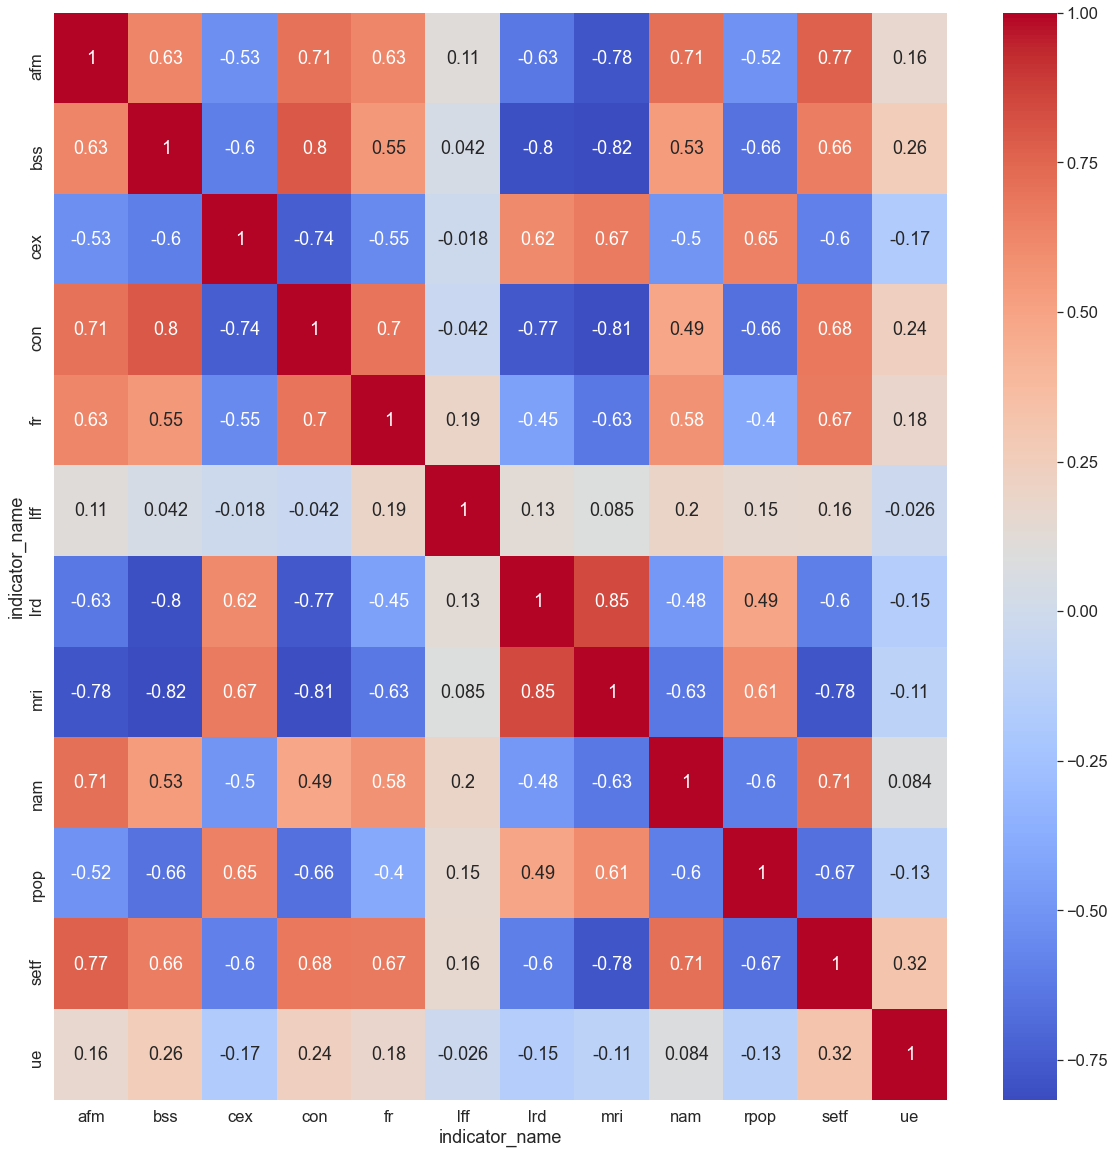

In [17]:
from sklearn.preprocessing import LabelEncoder

#convert fertility rate 'fr' to numeric 
le = LabelEncoder()
data_allscaled.fr = le.fit_transform(data_allscaled.fr)

#create correlation table
correlations = data_allscaled.corr()

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlations, annot=True, cmap='coolwarm')

If we focus on the 'fr' variable as our fertility rate, we see that the strongest correlation it has is 0.7 with 'con', which is our abbreviation for contraceptive prevelance. Although this is only moderate-high, there are still several other variables above 0.5 (or below -0.5) which indicate moderate correlations.

## Decision Tree and Machine Learning
Since the amount of observations is high compared to the number of factors, a low-bias, high-variance method like decision trees  is appropriate.  

First, separate our X and y.

In [18]:
#Recall 'fr' is our target variable
y_raw = data.fr
X_raw = data.drop('fr',axis=1)

### Data Encoding
Starting with the original (unscaled) data set, we'll encode the categorical variables so they can be used in the machine learning algorithms. Since our target variable ('fr' or fertility rate) has 2 levels, this can be done with LabelEncoder() as shown earlier. This will maintain one column of 0's and 1's. The 'Region' variable has 6 levels, so this will be encoded using OneHotEncoder() which will result in one column per level.  
I acknowledge that this is a form of data preprocessing, and that all preprocessing should be done after splitting train and test data. However this case is low risk: 'fr' has only two categories (above or below replacement fertility rate) and 'Region' consists of the 6 inhabited continents. These categories are at a low risk of being different in separate data sets.

In [19]:
le2 = LabelEncoder()
y =  le2.fit_transform(y_raw)

Use OneHotEncoder to encode 'Region':

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#we only want to apply OneHotEncoder to column [0], and 'pass through' the other columns. 
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse=False), [0])], remainder='passthrough')

#an array is needed for sklearn
X = np.array(ct.fit_transform(X_raw))

Split into training and test data, then scale according to training data only

In [21]:
from sklearn.model_selection import train_test_split

#split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

#scale according to x_train. We only want to scale the columns after 6, since the first 6 are the encoded region
scaler = StandardScaler()
X_train[:, 6:] = scaler.fit_transform(X_train[:, 6:])
X_test[:, 6:] = scaler.transform(X_test[:, 6:])


## Imputing
Before we proceed with the modelling, we'll need to impute the missing (NaN) values.
Let's look at how many missing values we have

In [22]:
print(f'Length of x_Train: {len(X_train)}')
pd.DataFrame(X_train).isnull().sum()

Length of x_Train: 158


0       0
1       0
2       0
3       0
4       0
5       0
6     103
7      86
8      71
9     120
10     11
11     15
12     22
13     40
14      7
15     64
16     13
dtype: int64

This is a lot of missing values. We don't want to delete them, or we'd lose most of our data set. Mean or median imputation are common to use, but again because we have so much missing data here I'm afraid that will skew the results. Therefore we'll use KNN imputation, where we predict each missing value based on K Nearest Neighbors. 

In [23]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()

imputer.fit(X_train)

#impute the data in X_train
X_train = imputer.transform(X_train)

#also use the same imputer on X_test
X_test = imputer.transform(X_test)

#to checked this worked, we will sum up the np.nan values in each array. We expect everything will be 0
print(f'X_train: {sum(np.isnan(X_train))}')
print(f'X_test: {sum(np.isnan(X_test))}')

X_train: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
X_test: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Grid search: choosing optimal parameters for machine learning model
As mentioned earlier, we are opting for the decision tree method. The first thing we want to do is determine which parameters are optimal. For decision trees, the main (although not only) parameter is the max_depth, so we will use grid search to optimize this one.
The grid search method uses cross validation with each possible pameter (or combination of parameters) to determine the optimal parameter(s). 

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state = 4)

params = {'max_depth': range(1,10)}

grid = GridSearchCV(classifier, params)

grid.fit(X_train, y_train)

print(f'Optimal max_depth value: {grid.best_params_}')

Optimal max_depth value: {'max_depth': 2}


From the grid search it appears the optimal max_depth is 2. We will work with this number. This suggests that a lower max_depth would be less accurate, and a higher max_depth would likely be overfitting.

## Decision Tree

In [25]:
#redefine classifier with max_depth = 2
classifier = DecisionTreeClassifier(max_depth = 2, random_state = 4)

classifier.fit(X_train, y_train)

#predict results of training set
y_pred = classifier.predict(X_test)

## Evaluating model

One way to evaluate the performance of the model is with a confusion matrix. Since we have 2 output categories, this will return a 2x2 matrix that will indicate the true-positives, false-positives, true-negatives, and false-negatives (assuming we use the convention that above replacement fertility rate (1) = positive and below replacement fertility rate (0) = negative)

### Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[19  6]
 [ 2 13]]


This looks reasonably good. 19 + 13 correct values, and 2 + 6 false values. 

### Accurracy
Another metric is accurracy (number correct predictions / total). It can be interesting to look at the accurracy of the model on both the training and the test data to see if there is any overfitting.

- Limit printout to 2 decimal places?

In [27]:
from sklearn.metrics import accuracy_score

#accuracy of test data
accuracy_test = accuracy_score(y_test, y_pred)

#predict result on training data with the model generated
y_train_pred = classifier.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)

print(f'Accurracy score on test data: {accuracy_test}')
print(f'Accurracy score on train data: {accuracy_train}')

Accurracy score on test data: 0.8
Accurracy score on train data: 0.8987341772151899


Our accuracy on the training data is a bit higher than on the test data which is to be expected, although a gap that's too large can indicate that the model is overfit. Normally we wouldn't expect that because we did a grid search to optimize the max_depth parameter. To see if max_depth was really optimized, let's make a graph.

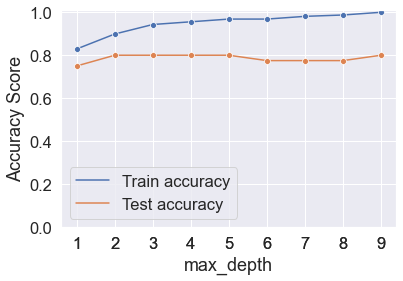

In [28]:
#make function to calculate accurracy value
def calc_accuracy(X, y, max_depth):
    classifier = DecisionTreeClassifier(max_depth = max_depth, random_state = 4)
    
    #we still fit the classifier with the X_train, y_train data sets 
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    
    return accuracy

train_accuracy = [calc_accuracy(X_train, y_train, i+1) for i in range(9)]
test_accuracy = [calc_accuracy(X_test, y_test, i+1) for i in range(9)]
max_depth_var = [i+1 for i in range(9)]

df = pd.DataFrame({'Train accuracy': train_accuracy, 
                   'Test accuracy': test_accuracy,
                   'max_depth': max_depth_var})

#create graph
df = pd.melt(df,id_vars = 'max_depth', value_name = 'Accuracy Score', var_name = 'Accuracy Type')
fig, ax = plt.subplots()
g = sns.lineplot(data=df, x='max_depth', y='Accuracy Score', hue='Accuracy Type', marker='o')
g.set_xticks(df.max_depth);
g.set_yticks(np.arange(0,1.2,0.2));
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles=handles[0:], labels=labels[0:]);


## Conclusion
It seems like the max_depth of 2 was a reasonable choice; complexer models don't have a large impact on the test accuracy. Considering our somewhat limited dataset (<200 observations) and the high amount of missing values we had to impute, the end result of accuracy = 0.8 isn't bad. 